# Analyze results of Multilabel classification on Yelp Dataset

This notebook analyzes the results of the yelp-multilabel ipython notebook. It expects the ests and gts arrays in the
same folder as files.

First, load the data, and create a dict that contains the ground truths for the businesses.

In [1]:
import numpy as np
gts = np.load('gts.npy')
ests = np.load('ests.npy')
business_ids = np.load('business_ids.npy')
photo_ids = np.load('photo_ids.npy')

In [2]:
# these are the Yelp classes, we'll need them later.
classes = np.asarray(['good_for_lunch', 'good_for_dinner', 'takes_reservations', 'outdoor_seating',
                      'restaurant_is_expensive', 'has_alcohol', 'has_table_service', 'ambience_is_classy',
                      'good_for_kids'])

In [3]:
from collections import defaultdict
# Create a dict with ground truths.
business_attr = defaultdict(list)
for gt, b_id in zip(gts, business_ids):
    attr = business_attr[b_id]
    # fill in ground truth only once.
    if not len(attr):
        business_attr[b_id] = gt

Then, write a function that can seperate the ests of images into the positive and negative classes.

In [4]:
def split_ests(class_of_interest):
    ests_positive = []
    ests_negative = []
    for preds, b_id in zip(ests, business_ids):
        if business_attr[b_id][class_of_interest] == 1:
            ests_positive.append(preds)
        else:
            ests_negative.append(preds)
    ests_positive = np.asarray(ests_positive)
    ests_negative = np.asarray(ests_negative)
    return ests_positive, ests_negative

Then, we can what percentage of images belong to restaurants that are 'good_for_lunch'

In [5]:
# Compare the number of elements in positive and negative classes.
ests_good_for_lunch, ests_bad_for_lunch = split_ests(0)
print 'Percentage of restautants that are ' + classes[0] + ': {0:.4f}'.format(len(ests_good_for_lunch)*100.0/len(ests))
print 'Percentage of restautants that are not ' + classes[0] + ': {0:.4f}'.format(len(ests_bad_for_lunch)*100.0/len(ests))

Percentage of restautants that are good_for_lunch: 22.5013
Percentage of restautants that are not good_for_lunch: 77.4987


Lets graph what the distribution of both groups looks like.

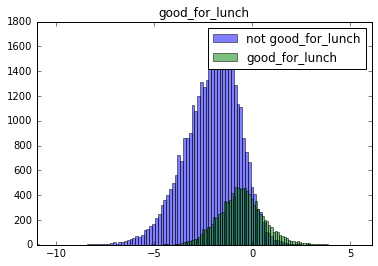

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

def plot_score(preds_positive_class, preds_negative_class, class_of_interest, bins):
    preds_positive_class_T = np.transpose(preds_positive_class)
    preds_negative_class_T = np.transpose(preds_negative_class)
    vals_positive = np.round(preds_positive_class_T[class_of_interest], decimals=2)
    vals_negative = np.round(preds_negative_class_T[class_of_interest], decimals=2)
    plt.hist(vals_negative, bins, alpha=0.5, label='not ' + classes[class_of_interest])
    plt.hist(vals_positive, bins, alpha=0.5, label=classes[class_of_interest] )
    plt.legend(loc='upper right')
    plt.title(classes[class_of_interest])

    plt.gca().set_xlim(vals_negative.min(), vals_positive.max())
    plt.show()

plot_score(ests_good_for_lunch, ests_bad_for_lunch, 0, 100)

The image distributions are not exactly seperable. This is to be expected, since we can't expect every image to show evidence of the class. Lets see if we can aggreagte images from one business and do something better.

First, create a dict that maps from business to the mean image scores. These are the predicted scores.

In [7]:
business_preds=defaultdict(list)
# First group by business.
for image_pred, b_id in zip(ests, business_ids):
    business_preds[b_id].append(image_pred)

# Then compute mean scores for each business.
for b_id, image_preds in business_preds.iteritems():
    # Take a mean for all images in one business.
    image_preds = np.asarray(image_preds)
    business_preds[b_id] = np.mean(image_preds, axis=0)

Now we'll write a function to seperate the aggregated estimates into positive and negative classes.

In [8]:
def split_preds(class_of_interest):
    preds_positive = []
    preds_negative = []
    for b_id, preds in business_preds.iteritems():
        if business_attr[b_id][class_of_interest] == 1:
            preds_positive.append(preds)
        else:
            preds_negative.append(preds)
    preds_positive = np.asarray(preds_positive)
    preds_negative = np.asarray(preds_negative)
    return preds_positive, preds_negative

Now, lets display this distribution for the good_for_lunch class.

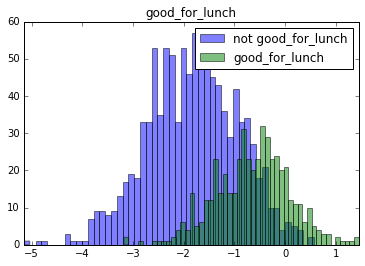

In [9]:
preds_good_for_lunch, preds_bad_for_lunch = split_preds(0)
plot_score(preds_good_for_lunch, preds_bad_for_lunch, 0, 50)

This shows that we are doing a reasonably good job of learning at the business level, even while training at the image level

Now, lets graph image and business level graphs for all classes.

In [10]:
def plot_image_distribution(class_of_interest):
    ests_positive, ests_negative = split_ests(class_of_interest)
    plot_score(ests_positive, ests_negative, class_of_interest, 100)

def plot_business_distribution(class_of_interest):
    preds_positive, preds_negative = split_preds(class_of_interest)
    plot_score(preds_positive, preds_negative, class_of_interest, 50)

Image distributions


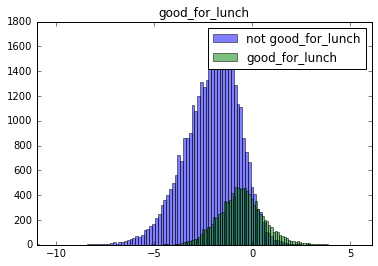

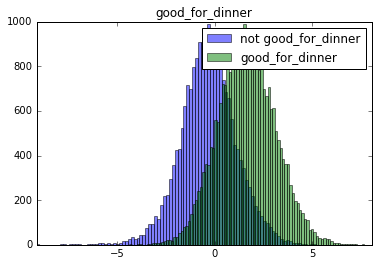

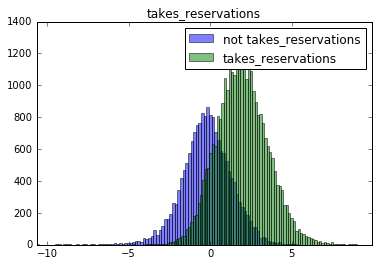

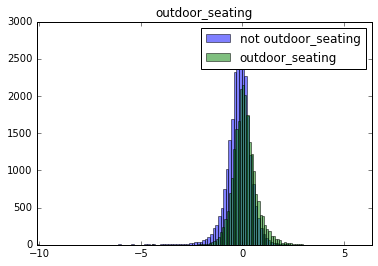

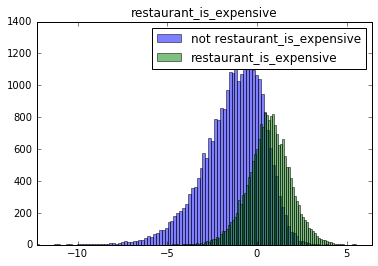

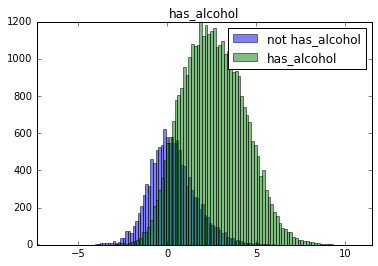

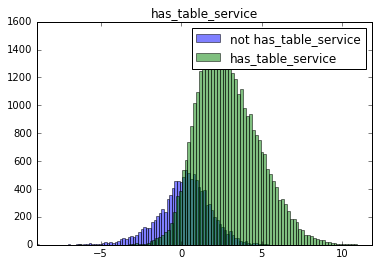

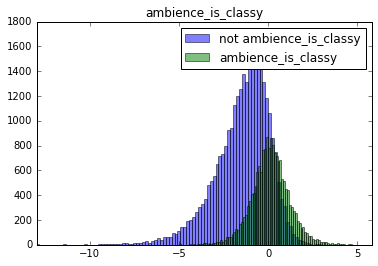

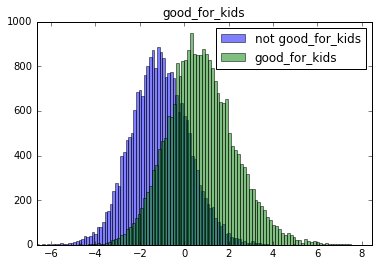

In [11]:
print "Image distributions"
for i in range(9):
    plot_image_distribution(i)

Business distributions


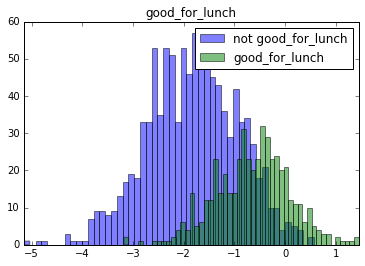

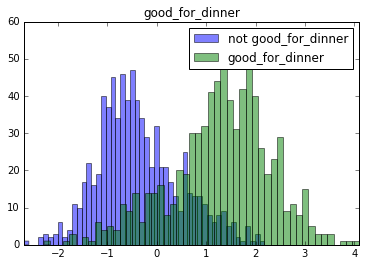

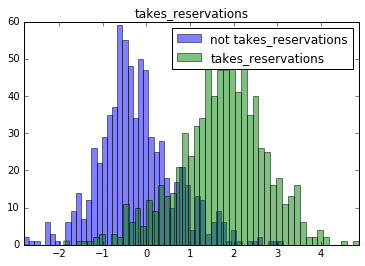

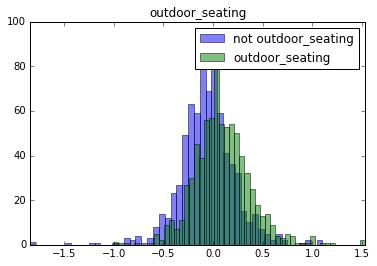

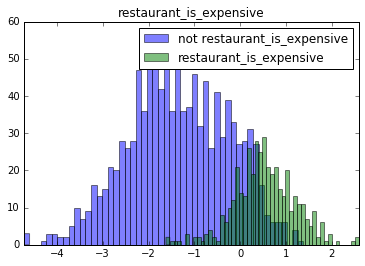

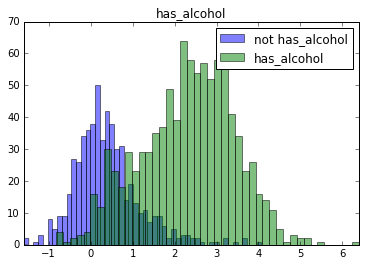

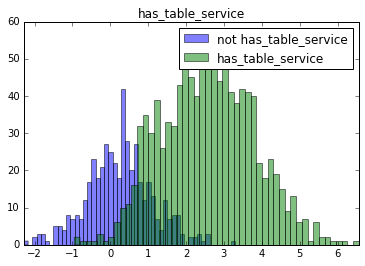

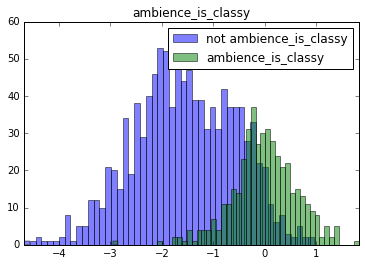

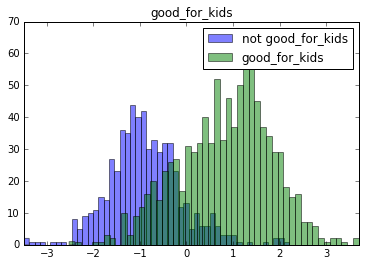

In [12]:
print "Business distributions"
for i in range(9):
    plot_business_distribution(i)

Lets do the old conversion from image labels to business label, and compute F1 score

In [13]:
import sys
sys.path.append('utils')
import photo2business
converter = photo2business.p2b()
business_labels = {}
for b_id, mean_preds in business_preds.iteritems():
    business_labels[b_id] = converter.convert_mean(mean_preds)

Now, lets compute F1 score to see how we did.

In [14]:
import mean_f1
def convert_to_labels(ts):
    labels = []
    for entry in ts:
        entry_labels = []
        for i in range(len(classes)):
            if entry[i] == 1:
                entry_labels.append(i)
        labels.append(entry_labels)
    return labels

def get_f1_score():
    ground_truths = []
    predicted_labels = []

    for b_id, labels in business_labels.iteritems():
        ground_truths.append(business_attr[b_id])
        predicted_labels.append(labels)
        
    # convert labels back from one-hot encoding.
    ground_truth_classes = convert_to_labels(ground_truths)
    predicted_label_classes = convert_to_labels(predicted_labels)
    print 'F1 score is: {0:.4f}'.format(mean_f1.mean_f1(ground_truth_classes, predicted_label_classes))
get_f1_score()

F1 score is: 0.7275


Lets convert photo scores to business labels using information about splits from the graphs above.

In [15]:
thresholds = [-0.4, 0.2, 0.5, 0.1, 0, 0.7, 0.8, -0.4, -0.1]
converter = photo2business.p2b(thresholds)
business_labels = {}
for b_id, mean_preds in business_preds.iteritems():
    business_labels[b_id] = converter.convert_mean(mean_preds)

get_f1_score()

F1 score is: 0.7712


In [16]:
# Thresholds from test data.
thresholds = [-1, 0.2, 0.5, 0.1, 0, 0.7, 0.8, -0.4, -0.1]
converter = photo2business.p2b(thresholds)
business_labels = {}
for b_id, mean_preds in business_preds.iteritems():
    business_labels[b_id] = converter.convert_mean(mean_preds)

get_f1_score()

F1 score is: 0.7796
